# Montecarlo Simulations

evolve the state of a system given a probability of transition from each state

The master equation example: I have a system where I want to keep track of the number of molecules in an environment.

the number of molecules can change due to two different processes:
* a particle from the outside can come in with a probability that is constant (or can be approximated as such)
* a particle can escape the system, with a probability that is constant for each particle (so the total probability is proportional to the number of particles)

In [14]:
import numpy as np
import pylab as plt
import random as rn

In [1]:
def removal(state):
    return state*0.1

def increase(state):
    return 1

transitions = [removal, increase]
transitions_names = ['removal', 'increase']

In [2]:
state = 5

In [3]:
rates = [f(state) for f in transitions]
rates

[0.5, 1]

### the Stochastic Simulation Algorithm

the total rate $\lambda_{tot}$ is the sum of the rates

the chance of each one happening is the proportion compared to the total rate

the time for which the system keeps being in the same state is distributed with an exponential time $\tau = \lambda_{tot}^{-1}$

In [4]:
total_rate = sum(rates)
total_rate

1.5

In [6]:
time = np.random.exponential(1/total_rate)
time

0.40834186657790317

### choosing the transition

we can use the same sampling method as before!

In [7]:
normalized_rates = np.cumsum(rates)
normalized_rates /= normalized_rates[-1]
normalized_rates

array([0.33333333, 1.        ])

In [11]:
p = np.random.rand()
idx = np.searchsorted(normalized_rates, p)
idx

0

In [12]:
event = transitions_names[idx]
event

'removal'

With python 3.6 onward, we can actually replace this with a simple call to `random.choices`, that handles weighted extractions

In [15]:
rn.choices(transitions_names, weights=rates)

['increase']

In [16]:
event = rn.choices(transitions_names, weights=rates)[0]
print(event)

increase


#### updating the status
given the chosen event we can update the current status and then start all over

In [17]:
if event == 'increase':
    state += 1
elif event == 'removal':
    state -= 1
else:
    raise ValueError("transition not recognized")

### the complete cycle

the complete simulation requires to keep track of which transition happened, how much time the system has spent in each status and so on.

one other thing we might want to keep track of is the total time ellapsed in the simulation.

When should we stop our simulation?

ideally weshould stop after a certain amount of "simulated time" has passed

In [21]:
import typing
from enum import Enum

In [73]:
class Transition(Enum):
    INCREASE = 'increase'
    DECREASE = 'removal'

class Observation(typing.NamedTuple):
    state: typing.Any
    time_of_observation: float
    time_of_residency: float
    transition: Transition

In [74]:
transitions = [removal, increase]
transitions_names = [Transition.DECREASE, Transition.INCREASE]

In [75]:
observed_states = []
state = 5
total_time = 0.0
time_limit = 5.0

while total_time < time_limit:
    rates = [f(state) for f in transitions]
    total_rate = sum(rates)
    time = np.random.exponential(1/total_rate)
    event = rn.choices(transitions_names, weights=rates)[0]
    
    observation = Observation(state, total_time, time, event)
    print(observation)
    observed_states.append(observation)
    
    total_time += time
    
    if event == Transition.INCREASE:
        state += 1
    elif event == Transition.DECREASE:
        state -= 1
    else:
        raise ValueError("transition not recognized")

Observation(state=5, time_of_observation=0.0, time_of_residency=1.1576834668798934, transition=<Transition.INCREASE: 'increase'>)
Observation(state=6, time_of_observation=1.1576834668798934, time_of_residency=0.6575216742677585, transition=<Transition.INCREASE: 'increase'>)
Observation(state=7, time_of_observation=1.815205141147652, time_of_residency=0.6123168602033375, transition=<Transition.INCREASE: 'increase'>)
Observation(state=8, time_of_observation=2.4275220013509893, time_of_residency=0.1612205808542916, transition=<Transition.DECREASE: 'removal'>)
Observation(state=7, time_of_observation=2.5887425822052808, time_of_residency=0.013946159842939045, transition=<Transition.INCREASE: 'increase'>)
Observation(state=8, time_of_observation=2.60268874204822, time_of_residency=0.15962782794158548, transition=<Transition.INCREASE: 'increase'>)
Observation(state=9, time_of_observation=2.7623165699898053, time_of_residency=1.007165858764632, transition=<Transition.INCREASE: 'increase'>)
Ob

let's make it a function so we have a more general way of managing it

In [33]:
def simulation(starting_state, time_limit):
    observed_states = []
    state = starting_state
    total_time = 0.0

    while total_time < time_limit:
        rates = [f(state) for f in transitions]
        total_rate = sum(rates)
        time = np.random.exponential(1/total_rate)
        event = rn.choices(transitions_names, weights=rates)[0]

        observation = Observation(state, total_time, time, event)
        observed_states.append(observation)

        total_time += time

        if event == Transition.INCREASE:
            state += 1
        elif event == Transition.DECREASE:
            state -= 1
        else:
            raise ValueError("transition not recognized")
    return observed_states

In [44]:
time_limit = 100
result = simulation(starting_state=5, time_limit=time_limit)

In [45]:
len(result)

183

In [46]:
for res in result[-5:]:
    print(res)

Observation(state=11, time_of_observation=97.69823788896771, time_of_residency=0.5379031506382671, transition='increase')
Observation(state=12, time_of_observation=98.23614103960598, time_of_residency=0.03383685380927434, transition='increase')
Observation(state=13, time_of_observation=98.26997789341526, time_of_residency=0.2043946593745321, transition='removal')
Observation(state=12, time_of_observation=98.47437255278979, time_of_residency=0.18525206620652507, transition='increase')
Observation(state=13, time_of_observation=98.65962461899632, time_of_residency=2.093541777733141, transition='increase')


One thing we can observe is that the last state overshoot the time limit a bit for any simulation we could do.

The solution to this is to trim the time the system stays in the state so that the final overall time is exactly equal to the given limit.

Being processes with constant probability in time this does not deform the probabilities.

for now we can ignore it, but will come back later to this, because it is also related to problem of absorbing states and fixed time events.

### final probability distribution

to estimate the probability of observing our system in a given state, we have to sum up the time the system has spent in each state.

**BEWARE**: the probability depends on the time of residency, not on the number of times that state has appeared!

the expected distribution for this process is a poisson distribution with average 10

In [37]:
from collections import Counter

In [47]:
distribution = Counter()
for observation in result:
    state = observation.state
    residency_time = observation.time_of_residency
    distribution[state] += residency_time/time_limit
print(distribution)

Counter({6: 0.1810825649905063, 7: 0.17773802892093074, 10: 0.12009298554010898, 8: 0.11701780242644835, 5: 0.1045594131140146, 9: 0.10012776036136828, 4: 0.06683411623399652, 2: 0.04075748196621793, 11: 0.03384832466978104, 3: 0.027854327063525638, 13: 0.023978642908255007, 12: 0.008570114931658088, 1: 0.0050701008404824156})


In [48]:
import scipy.stats as st

<BarContainer object of 20 artists>

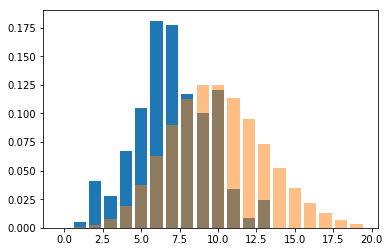

In [49]:
fig, ax = plt.subplots()
ax.bar(distribution.keys(), distribution.values())

values = np.arange(20)
pmf = st.poisson(10).pmf(values)
ax.bar(values, pmf, alpha=0.5)

let's make it run for longer...

In [59]:
def generate_distribution(observation_sequence):
    distribution = Counter()
    for observation in observation_sequence:
        state = observation.state
        residency_time = observation.time_of_residency
        distribution[state] += residency_time/time_limit
    return distribution

In [60]:
time_limit = 1_000
result = simulation(starting_state=5, time_limit=time_limit)
distribution = generate_distribution(result)


<BarContainer object of 20 artists>

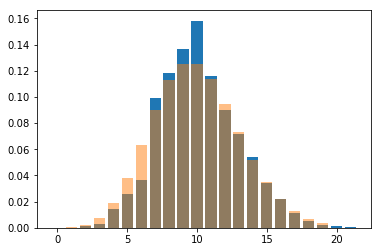

In [61]:
fig, ax = plt.subplots()
ax.bar(distribution.keys(), distribution.values())

values = np.arange(20)
pmf = st.poisson(10).pmf(values)
ax.bar(values, pmf, alpha=0.5)

### warn-in period

for monodimensional systems it's relatively easy to converge to the right distribution, but the starting point can have a substancial effect!

In [62]:
time_limit = 1_000
result = simulation(starting_state=50, time_limit=time_limit)
distribution = generate_distribution(result)


<BarContainer object of 20 artists>

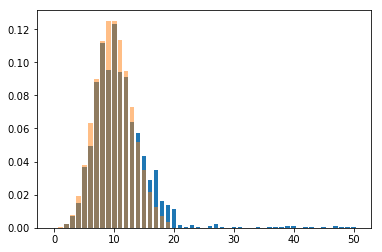

In [63]:
fig, ax = plt.subplots()
ax.bar(distribution.keys(), distribution.values())

values = np.arange(20)
pmf = st.poisson(10).pmf(values)
ax.bar(values, pmf, alpha=0.5)

usually for these kind of simulations the first period of time gets removed to avoid problem of convergence

### multiple simulations

Estimating the convergence to the final distribution can be quite hard with a single simulation, so a good rule of thumb is to run at least 3 or 4 identical simulations to assess how much the convergence has been reached

In [64]:
time_limit = 1_000
result_1 = simulation(starting_state=50, time_limit=time_limit)
result_2 = simulation(starting_state=50, time_limit=time_limit)
result_3 = simulation(starting_state=50, time_limit=time_limit)

In [65]:
def plot_observations(observation_sequence, ax=None):
    if ax is None:
        ax = plt.gca()
    values = [obs.state for obs in observation_sequence]
    times = [obs.time_of_observation for obs in observation_sequence]
    ax.plot(times, values, linestyle='steps-post')

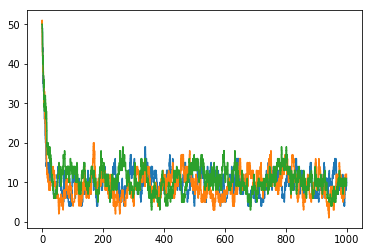

In [67]:
fig, ax = plt.subplots()
plot_observations(result_1)
plot_observations(result_2)
plot_observations(result_3)

## Absorbing states

an absorbing state is one where the transition rates for all the possible transitions is equal to zero.

When this happens, the expected residency time becomes infinite (the system is stuck there)

let's rewrite our functions so that 0 is an absorbing state

In [94]:
class Transition(Enum):
    INCREASE = 'increase'
    DECREASE = 'removal'
    ABSORPION = 'absorbed'

In [95]:
def removal_absorbing(state):
    return state*0.5

def increase_absorbing(state):
    return 1 if state>0 else 0

transitions = [removal_absorbing, increase_absorbing]
transitions_names = [Transition.DECREASE, Transition.INCREASE]

In [96]:
state = 0

In [97]:
rates = [f(state) for f in transitions]
rates

[0.0, 0]

In [98]:
total_rate = sum(rates)
total_rate

0.0

In [99]:
time = np.random.exponential(1/total_rate)
time

ZeroDivisionError: float division by zero

In [100]:
if total_rate>0:
    time = np.random.exponential(1/total_rate)
else:
    time = np.inf
time

inf

at this point we should not be advancing anymore!

In [104]:
def simulation(starting_state, time_limit, transitions, transitions_names):
    observed_states = []
    state = starting_state
    total_time = 0.0

    while total_time < time_limit:
        rates = [f(state) for f in transitions]
        total_rate = sum(rates)
        if total_rate>0:
            time = np.random.exponential(1/total_rate)
            event = rn.choices(transitions_names, weights=rates)[0]
        else:
            time = np.inf
            event = Transition.ABSORPION
            
        observation = Observation(state, total_time, time, event)
        observed_states.append(observation)

        total_time += time

        if event == Transition.INCREASE:
            state += 1
        elif event == Transition.DECREASE:
            state -= 1
        elif event == Transition.ABSORPION:
            pass
        else:
            raise ValueError("transition not recognized")
    return observed_states

In [105]:
result = simulation(5, time_limit=100,
                    transitions=[removal_absorbing, increase_absorbing],
                    transitions_names=[Transition.DECREASE, Transition.INCREASE])

In [108]:
for observation in result:
    print(observation)
    print()

Observation(state=5, time_of_observation=0.0, time_of_residency=0.8847778075788821, transition=<Transition.INCREASE: 'increase'>)

Observation(state=6, time_of_observation=0.8847778075788821, time_of_residency=0.17300067447308484, transition=<Transition.DECREASE: 'removal'>)

Observation(state=5, time_of_observation=1.057778482051967, time_of_residency=0.2858634978377892, transition=<Transition.DECREASE: 'removal'>)

Observation(state=4, time_of_observation=1.343641979889756, time_of_residency=0.5703395307699232, transition=<Transition.DECREASE: 'removal'>)

Observation(state=3, time_of_observation=1.9139815106596791, time_of_residency=0.543502327659089, transition=<Transition.DECREASE: 'removal'>)

Observation(state=2, time_of_observation=2.457483838318768, time_of_residency=0.17592568856497076, transition=<Transition.DECREASE: 'removal'>)

Observation(state=1, time_of_observation=2.6334095268837387, time_of_residency=0.512983143795379, transition=<Transition.DECREASE: 'removal'>)

Ob

## fixed time events

One possibility that wemight be interested in could be to register events happening at fixed point in time (or space, if we are describing the movement of an object).

the advantage of working with markovian transitions is that there is no problem interrupting at a fixed point in time and then keep going from there as nothign happened!

In [109]:
class Transition(Enum):
    INCREASE = 'increase'
    DECREASE = 'removal'
    ABSORPION = 'absorbed'
    RINGTONE = 'ringtone'


In [110]:
def removal_absorbing(state):
    return state*0.5

def increase_absorbing(state):
    return 1 if state>0 else 0

transitions = [removal_absorbing, increase_absorbing]
transitions_names = [Transition.DECREASE, Transition.INCREASE]

In [111]:
state = 5

In [112]:
rates = [f(state) for f in transitions]
rates

[2.5, 1]

In [113]:
total_rate = sum(rates)
total_rate

3.5

In [115]:
proposed_residency_time = np.random.exponential(1/total_rate)
proposed_residency_time

0.22049078206635592

In [116]:
current_time = 0.1

In [117]:
time_ringtone = 0.3

In [118]:
if current_time<time_ringtone and current_time + proposed_residency_time > time_ringtone:
    proposed_residency_time = time_ringtone - current_time
    event = Transition.RINGTONE
else:
    pass

In [119]:
event

<Transition.RINGTONE: 'ringtone'>

note that we have to decide how to interact with the absorbing states!
my personal preference is to give priority to the timed events, as they might change the parameters of the simulation and change and absorbing point into a non absorbing one

In [132]:
def simulation(starting_state, time_limit, transitions, transitions_names):
    observed_states = []
    state = starting_state
    total_time = 0.0

    while total_time < time_limit:
        rates = [f(state) for f in transitions]
        total_rate = sum(rates)
        if total_rate>0:
            time = np.random.exponential(1/total_rate)
            event = rn.choices(transitions_names, weights=rates)[0]
        else:
            time = np.inf
            event = Transition.ABSORPION
        
        # the fixed events overrides the others if they would happen before the chosen time
        time_ringtone = 1.0
        if total_time < time_ringtone and total_time + time > time_ringtone:
            time = time_ringtone - total_time
            event = Transition.RINGTONE
            
        observation = Observation(state, total_time, time, event)
        observed_states.append(observation)

        total_time += time

        if event == Transition.INCREASE:
            state += 1
        elif event == Transition.DECREASE:
            state -= 1
        elif event == Transition.ABSORPION or event == Transition.RINGTONE:
            pass
        else:
            raise ValueError("transition not recognized")
    return observed_states

In [133]:
result = simulation(5, time_limit=100,
                    transitions=[removal_absorbing, increase_absorbing],
                    transitions_names=[Transition.DECREASE, Transition.INCREASE])

In [135]:
for observation in result[:5]:
    print(observation)
    print()

Observation(state=5, time_of_observation=0.0, time_of_residency=0.2861226830751954, transition=<Transition.DECREASE: 'removal'>)

Observation(state=4, time_of_observation=0.2861226830751954, time_of_residency=0.20901332774897743, transition=<Transition.INCREASE: 'increase'>)

Observation(state=5, time_of_observation=0.4951360108241728, time_of_residency=0.005714842148904791, transition=<Transition.INCREASE: 'increase'>)

Observation(state=6, time_of_observation=0.5008508529730776, time_of_residency=0.49914914702692237, transition=<Transition.RINGTONE: 'ringtone'>)

Observation(state=6, time_of_observation=1.0, time_of_residency=0.09120688240794557, transition=<Transition.DECREASE: 'removal'>)



## Continuous time random walk

these simulations are the basics for the generalization to the continuous time random walk simulation.

These are used for example to simulate the behavior of high energy particles in matter to study the image resolution properties of certain instrumental settings, or as input for deep neural models for superresolution and so on.

In particle simulation for example the events are going to be related to a particle, that can generate new particles on its way (for example by ionization).

The fixed time events are replaced by geometrical considerations, but the underlying concept is the same.

## Exercise

there are still many things that can be done to implement this simulator:

1. allow the user to specify the effect of the various transitions
2. return the simulation not as a list, but as a dedicated objct that can :
    * be sliced over time: `my_simulation[0.5:100.0]`
    * have a plot function dedicated
    * automatically estimate the distribution
3. always include multiple runs of the simulation, an djoin this with point 2